In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np

##### Get data

In [2]:
data = pd.read_csv("KCB.csv", parse_dates=['datetime'])
data.columns = ['date', 'symbol', 'open', 'high', 'low', 'close', 'volume']
data['date'] = data['date'].dt.date
data.set_index(['date'], inplace=True)
data.head()

,symbol,open,high,low,close,volume
date,,,,,,
1995-04-24,NSEKE:KCB,2.973207,2.973207,2.877298,2.973207,119599.010803
1995-04-25,NSEKE:KCB,2.901275,2.901275,2.877298,2.901275,63470.444928
1995-04-27,NSEKE:KCB,2.877298,2.901275,2.853320,2.877298,36211.977984
1995-04-28,NSEKE:KCB,2.877298,2.877298,2.877298,2.877298,175767.370061
1995-05-02,NSEKE:KCB,2.877298,2.877298,2.877298,2.877298,0.000000


##### 

##### Visualize data

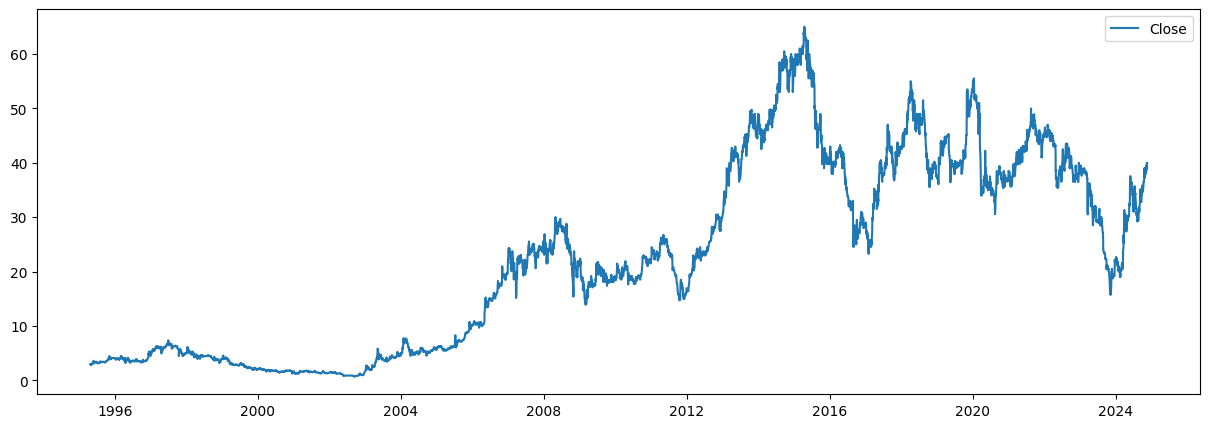

In [3]:
plt.figure(figsize=(15, 5))
plt.plot(data['close'], label='Close')
plt.legend()
plt.show()


##### Working on trading logic and calculating returns

In [4]:
def get_moving_averages(data:pd.DataFrame, sma_small:int, sma_large:int):
    data[f"sma_{sma_small}"] = data['close'].rolling(window=sma_small).mean()
    data[f"sma_{sma_large}"] = data['close'].rolling(window=sma_large).mean()
    data['delta'] = data[f"sma_{sma_small}"] - data[f"sma_{sma_large}"]
    data['delta_prev'] = data['delta'].shift(1)
    data.dropna(inplace=True)
    return data


def sma_crossover(data:pd.DataFrame, shorts:bool=False):
    data['position'] = np.nan
    data['position'] = np.where((data['delta']>=0) & (data['delta_prev']<0), 1, data['position'])
    if shorts:
        data['position'] = np.where((data['delta']<0)&(data['delta_prev']>=0), -1, data['position'])
    else:
        data['position'] = np.where((data['delta']<0)&(data['delta_prev']>=0), 0, data['position'])
        
    data['position'] = data['position'].ffill().fillna(0)
    return calc_returns(data)


def calc_returns(data):
    data['returns'] = data['close'].div(data['close'].shift(1))
    data['log_returns'] = np.log(data['returns'])
    data['strategy_returns'] = data['returns'] * data['position'].shift(1)
    data['strategy_log_returns'] = data['log_returns'] * data['position'].shift(1)
    data['cum_returns'] = data['log_returns'].cumsum().apply(np.exp)
    data['strategy_cum_returns'] = data['strategy_log_returns'].cumsum().apply(np.exp)
    data['peak'] = data['cum_returns'].cummax()
    data['strategy_peak'] = data['strategy_cum_returns'].cummax()
    return data


def get_strategy_stats(log_returns: pd.Series, risk_free_rate: float  = 0.083925 ):
    stats = {}
    stats['tot_returns'] = np.exp(log_returns.sum()) - 1
    stats['annual_returns'] = np.exp(log_returns.mean() * 252) - 1
    stats['annual_volatility'] = log_returns.std() * np.sqrt(252)
    annualised_downside = log_returns.loc[log_returns < 0 ].std() * np.sqrt(252)
    stats['sortino_ratio'] = (stats['annual_returns'] - risk_free_rate) / annualised_downside
    stats['sharpe_ratio'] = (stats['annual_returns'] - risk_free_rate) / stats['annual_volatility']
    cum_returns = log_returns.cumsum()
    peak = cum_returns.cummax()
    draw_down = peak - cum_returns
    max_idx = draw_down.argmax()
    stats['max_dd'] = 1 - np.exp(cum_returns.iloc[max_idx]) / np.exp(peak.iloc[max_idx])
    strat_dd = draw_down[draw_down==0]
    strat_dd_diff = strat_dd.index[1:] - strat_dd.index[:-1]
    strat_dd_days = strat_dd_diff.map(lambda x: x.days).values
    strat_dd_days = np.hstack([strat_dd_days, (draw_down.index[-1] - strat_dd.index[-1]).days ])
    stats['max_dd_duration'] = strat_dd_days.max()
    return {k: np.round(v, 4) if type(v) == float else v for k, v in stats.items()}
    

#### Visualize the results

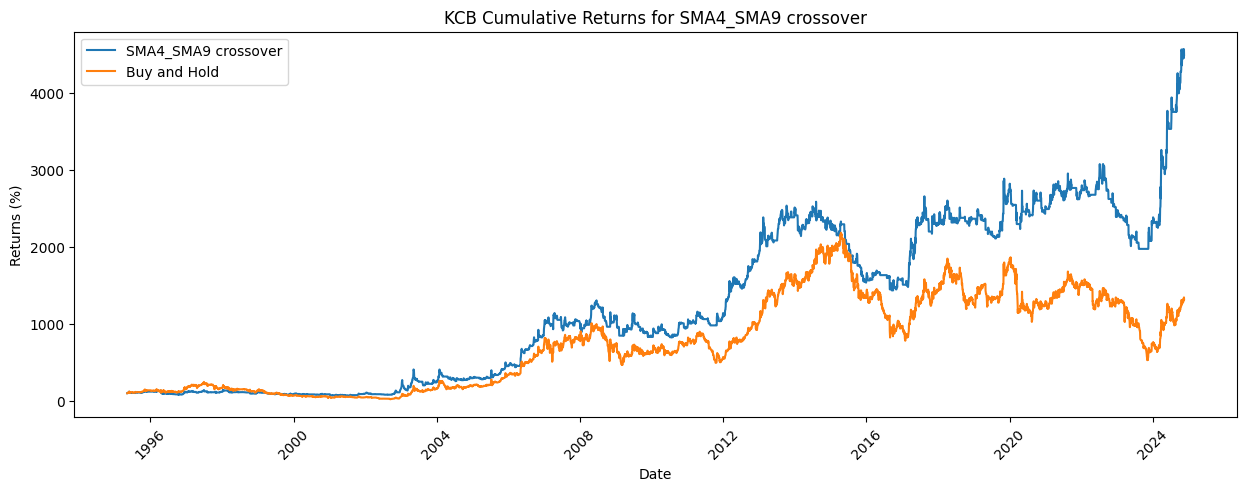

,tot_returns,annual_returns,annual_volatility,sortino_ratio,sharpe_ratio,max_dd,max_dd_duration
Buy and Hold,12.234865,0.094038,0.384710,0.03190,0.026288,0.910145,3500
SMA4_SMA9 crossover,43.965715,0.141604,0.269801,0.18857,0.213782,0.516236,1814


In [5]:
data = get_moving_averages(data, sma_small=4, sma_large=9)
sma_cross = sma_crossover(data.copy(), shorts=False)

plt.figure(figsize=(15, 5))
plt.plot(sma_cross["strategy_cum_returns"] * 100 , label="SMA4_SMA9 crossover")
plt.plot(sma_cross["cum_returns"] * 100 , label="Buy and Hold")
plt.title("KCB Cumulative Returns for SMA4_SMA9 crossover")
plt.xlabel("Date")
plt.ylabel("Returns (%)")
plt.xticks(rotation=45)
plt.legend()

plt.show()

stats = pd.DataFrame(get_strategy_stats(sma_cross["log_returns"]), 
                     index=["Buy and Hold"])
stats = pd.concat([stats,
                   pd.DataFrame(get_strategy_stats(sma_cross["strategy_log_returns"]),
                               index=["SMA4_SMA9 crossover"])])
stats